In [1]:
%cd /kaggle/working
%rm -rf /kaggle/working/*

/kaggle/working


In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from torchmetrics import MetricCollection, MeanSquaredError
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from consts import ANGLEZ_MEAN, ANGLEZ_STD, ENMO_MEAN, ENMO_STD
from torch_model.dataset import ZzzPatchDataset
from torch_model.gru_model import ZzzTransformerGRUModule

MODEL_NAME = "pseudo_labeling_retrain"

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base_torch(CFG["env"]["seed"])

BLOCK_SIZE = CFG[MODEL_NAME]["execution"]["block_size"]

2023-10-25 05:01:07.984440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-10-25 05:01:07.985371: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-10-25 05:01:07.985377: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

exp_0105


In [3]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
cv_split.loc[cv_split["fold"].isin([0, 1, 2]), "fold"] = 0
cv_split.loc[cv_split["fold"].isin([3, 4]), "fold"] = 1
series_id2fold = dict(zip(cv_split["series_id"], cv_split["fold"]))

In [4]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
dfs = []
for file in tqdm(files):
    df = pd.read_parquet(file)
    series_id = df["series_id"].unique()[0]
    fold = series_id2fold[series_id]
    df["fold"] = fold
    if fold == 1:
        oof = pd.read_parquet(os.path.join("/kaggle/output", CFG["pseudo_labeling"]["execution"]["best_exp_id"], "oof.parquet"), filters=[('series_id','=',series_id)])
        df = df.merge(oof, on=["series_id", "step"], how="left")        
        df[["wakeup_target", "onset_target"]] = df[["wakeup_oof", "onset_oof"]]
        df[["wakeup_target", "onset_target"]] = df[["wakeup_target", "onset_target"]].interpolate(method="linear", limit_direction="both")
        df = df.drop(["wakeup_oof", "onset_oof"], axis=1)
    dfs.append(df)
train = pd.concat(dfs, axis=0).reset_index(drop=True)

100%|██████████| 277/277 [01:15<00:00,  3.67it/s]


In [5]:
# 標準化
train["anglez"] = (train["anglez"] - ANGLEZ_MEAN) / ANGLEZ_STD
train["enmo"] = (train["enmo"] - ENMO_MEAN) / ENMO_STD
train["anglez_diff"] = train["anglez"].diff().fillna(0)
train["enmo_diff"] = train["enmo"].diff().fillna(0)

# targetは01にする
train["onset_target"] = train["onset_target"] / 10
train["wakeup_target"] = train["wakeup_target"] / 10

In [6]:
# BLOCK_SIZE ごとに分割
dfs = []
for series_id, df in tqdm(train.groupby("series_id")):
    df = df.sort_values("step").reset_index(drop=True)

    for start in range(0, len(df), BLOCK_SIZE // 8):
        end = start + BLOCK_SIZE
        if end > len(df):
            # endをlen(df)未満の最大のpsの倍数にする
            end = len(df) - len(df) % CFG[MODEL_NAME]["execution"]["patch_size"]
            start = end - BLOCK_SIZE
            assert start >= 0
        assert df.iloc[start]["step"] % CFG[MODEL_NAME]["execution"]["patch_size"] == 0
        dfs.append(df.iloc[start: end])
gc.collect()

features = Features()
features.add_num_features(["anglez", "enmo"])
features.add_num_features(["anglez_diff", "enmo_diff"])
dataset_oof = ZzzPatchDataset(dfs, 'train', features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
feats, targets = dataset_oof[0]
feats.shape, targets.shape

100%|██████████| 277/277 [00:30<00:00,  9.17it/s]


((1600, 48), (1600, 2))

In [7]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [9]:
%%time

fold_oof_dfs = []
fold = 1
print(f"== fold {fold} ==")

# 学習・評価データ
train_dfs = dfs
valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
train_dataset = ZzzPatchDataset(train_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
valid_dataset = ZzzPatchDataset(valid_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

# モデル
num_training_steps = len(train_dataset) // 32 * 10
model = ZzzTransformerGRUModule(
    max_len=BLOCK_SIZE // CFG[MODEL_NAME]["execution"]["patch_size"],
    input_numerical_size=len(features.all_features()) * CFG[MODEL_NAME]["execution"]["patch_size"],
    **CFG[MODEL_NAME]["params"],
    lr=0.001, 
    dropout=0.0, 
    loss_fn=nn.BCEWithLogitsLoss(),
    num_training_steps=num_training_steps,
    )

# コールバック
cp_callback = ModelCheckpoint(
    "logs/", 
    filename=f"best_model_fold{fold}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=False,
)
es_callback = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=8,
)

# 学習
trainer = pl.Trainer(
    callbacks=[cp_callback, es_callback],
    deterministic=True,
    val_check_interval=0.25,
    )
trainer.fit(model, datamodule=data_module)

# 推論
model = ZzzTransformerGRUModule.load_from_checkpoint(
    f"logs/best_model_fold{fold}.ckpt", 
    max_len=BLOCK_SIZE // CFG[MODEL_NAME]["execution"]["patch_size"],
    input_numerical_size=len(features.all_features()) * CFG[MODEL_NAME]["execution"]["patch_size"],
    **CFG[MODEL_NAME]["params"],
    loss_fn=nn.BCEWithLogitsLoss()).to("cuda")
model.eval()
preds = []
with torch.no_grad():
    for X, y in data_module.val_dataloader():
        pred = torch.sigmoid(model(X.to("cuda"))).detach().cpu().numpy() * 10
        preds.append(pred)

oof_dfs = []
for pred, df in zip(np.vstack(preds), valid_dfs):
    df = df.iloc[CFG[MODEL_NAME]["execution"]["patch_size"] // 2: len(df): CFG[MODEL_NAME]["execution"]["patch_size"]].reset_index(drop=True)
    df[["wakeup_oof", "onset_oof"]] = pred
    oof_dfs.append(df)

oof_df = pd.concat(oof_dfs)
oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
fold_oof_dfs.append(oof_df[["series_id", "step", "wakeup_oof", "onset_oof"]])

del model, preds, oof_df, oof_dfs
gc.collect()
# break

train = pd.concat(fold_oof_dfs)
train.to_parquet(f"{CFG['output_dir']}/oof.parquet", index=False)
del fold_oof_dfs
gc.collect()

== fold 1 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.8019, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0571, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0219, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0215, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0213, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0214, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0213, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0212, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0214, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0212, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0213, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0213, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0213, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0218, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0214, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0214, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0217, 


Validation: 0it [00:00, ?it/s]

CPU times: user 1h 23min, sys: 3min 9s, total: 1h 26min 10s
Wall time: 36min 23s


0

415001

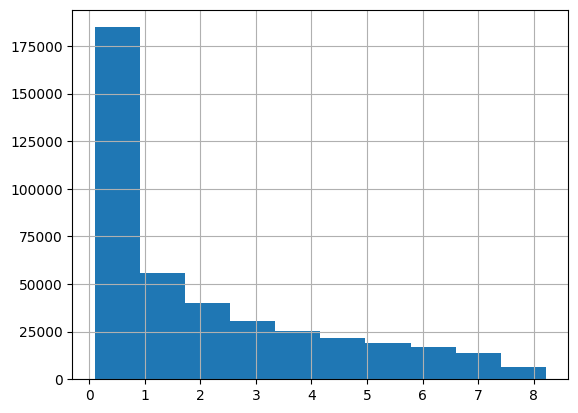

In [10]:
dfs = []
df = train[["series_id", "step", "wakeup_oof"]].copy()
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = train[["series_id", "step", "onset_oof"]].copy()
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs)
train = train[train["score"]>0.1].reset_index(drop=True)
train["score"].hist()
len(train)

## Dynamic-Range NMS

In [11]:
train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]











100%|██████████| 111/111 [00:02<00:00, 42.82it/s]


In [12]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.7408


event   tolerance
onset   12           0.228170
        36           0.599294
        60           0.704555
        90           0.756267
        120          0.798595
        150          0.820218
        180          0.838613
        240          0.850874
        300          0.858548
        360          0.864297
wakeup  12           0.233256
        36           0.636783
        60           0.726831
        90           0.774552
        120          0.816894
        150          0.831326
        180          0.849032
        240          0.865376
        300          0.877680
        360          0.884877
dtype: float64

In [13]:
%cp -r logs {CFG["output_dir"]}

In [14]:
train

,series_id,step,event,score
0,03d92c9f6f8a,30,wakeup,0.119386
1,03d92c9f6f8a,42,wakeup,0.123000
2,03d92c9f6f8a,54,wakeup,0.123484
3,03d92c9f6f8a,66,wakeup,0.120225
4,03d92c9f6f8a,78,wakeup,0.115870
...,...,...,...,...
414996,fcca183903b7,619698,onset,0.143950
414997,fcca183903b7,619710,onset,0.133418
414998,fcca183903b7,619722,onset,0.122847
414999,fcca183903b7,619734,onset,0.111910


In [15]:
sub["fold"] = sub["series_id"].map(cv_split.set_index("series_id")["fold"])
sub.loc[sub["fold"].isin([0, 1, 2]), "fold"] = 0
sub.loc[sub["fold"].isin([3, 4]), "fold"] = 1

for fold, df in sub.groupby("fold"):
    # スコア計算
    labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
    labels = labels[labels["series_id"].isin(df["series_id"].unique())]
    score, ap_table = compute_comptetition_metric(labels, df)

    print(f"fold: {fold}")
    print(f"score: {score:.4f}")

fold: 0
score: 0.7408
